In [2]:
#Importing all the necessary libraries required for our Decision Tree AI
import numpy as np
import pandas as pd
from sklearn.tree import export_text
from sklearn.tree import export_graphviz
from six import StringIO 
import csv
from IPython.display import Image
import pydotplus
from termcolor import colored
from sklearn.model_selection import train_test_split
import json
from sklearn.tree import DecisionTreeClassifier
from nbconvert import PythonExporter
from sklearn import metrics
import firebase_admin
from firebase_admin import credentials,storage
from firebase_admin import firestore
import datetime

In [3]:
#Initializing the firestore client to connect to our website database
if not firebase_admin._apps:
   
   ### Fetch the service account key JSON file contents
   cred = credentials.Certificate("services/we-don-t-byte---ass-firebase-adminsdk-kdbj6-ec500ebd6d.json")

   ### Initialize the app with a service account, granting admin privileges
   app = firebase_admin.initialize_app(cred, {"storageBucket": "we-don-t-byte---ass.appspot.com"})

   bucket = storage.bucket(app=app)
   
   db = firestore.client()

In [4]:
#------------------------------------------------------------------------ DATA COLLECTION-------------------------------------------------------------------

### Address of csv data to be downloaded
blob = bucket.blob("CSV files/test.csv")

### Generate a link which contains our csv data.
CSV_URL= blob.generate_signed_url(datetime.timedelta(seconds=300), method='GET')

### Reading our csv file from URL...
df = pd.read_csv(CSV_URL)

In [5]:
df

,Product_Id,Product_Name,Product_Category,User_ID,User_Location,User_Province,Event,Cost,Date,Recommend
0,RlELjHnEOH1FqFFonlyH,Marisa Sandals,Shoes,xGGtTI4nXAaGemqiXS5XUKzQITG2,"2078 Block H, Soshanguve, Pretoria",Gauteng,view,313.0,2021-09-06 20:29:00.000,yes
1,4ymJ04p8GXQUofMZAm4Q,Prada tee,Clothing,d2xjFegkYrbaYVUllZbwOnMPcs22,"centuty Boulevard,Centtury ,milnerton",Western cape,view,202.0,2021-09-06 20:28:00.000,yes
2,kL2V5Ca2K6blsBGHBCKH,St James Cambridge 18/10 6pc Teaspoon Set,Kitchen,hWB4qgFYtIfJABvjq3XfEsxiGVU2,"75 Douglas St, Aqua Park, Tzaneen, 0850",Limpopo,view,160.0,2021-09-06 16:30:00.000,yes
3,dthOIOlKHaY11h6dO990,Triple Memory,Tech,NaN,NaN,NaN,NaN,463.0,2021-09-05 17:48:00.000,yes
4,qPJVoEpTTxQxUNaoJOc9,Spongebob yeezy slides,Shoes,6OqQDrHmcXS1RWrAXFvvwtNPgdh1,"Wintersveld 427M-S Iphofolo Game Farm, Vivo, 0924",Limpopo,view,313.0,2021-09-06 17:32:00.000,yes
...,...,...,...,...,...,...,...,...,...,...
949,6RLn3IvalL7iOouUbTV9,Arizona EVA slides,Shoes,NaN,NaN,NaN,NaN,448.0,2021-09-05 17:48:00.000,yes
950,2dwQEqgLfoP6PyEz2gXc,green honeycomb keyboard,Tech,d2xjFegkYrbaYVUllZbwOnMPcs22,"centuty Boulevard,Centtury ,milnerton",Western cape,view,249.0,2021-09-06 20:29:00.000,yes
951,A4NA70WHNGK10Z4OenFu,Donald duck disney t-shirts,Clothing,EFyklpIRA3Y6W6u10wFrV0qmIYH2,"Plot 30 Magoebaskloof Road, R71, Tzaneen, 0850",Limpopo,cart,457.0,2021-09-06 16:38:00.000,no
952,uPlXoA0jGjOyHVCZ7l17,USB jewellery,Tech,NaN,NaN,NaN,NaN,3745.0,2021-09-05 17:48:00.000,yes


In [6]:
#------------------------------------------------------------------------------------DATA CLEANING AND PREPROCESSING--------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### Removing unneccessary columns from our table
del df['Cost']
del df['Date']
del df['Product_Name']
del df['User_Location'] ### Note this is the exact location, not the "Province" that we'll be using....

##Inserting new columns
df.insert(5, 'Clicks', 1) ### Creating a column "clicks" to store the number of clicks a certain product has... 
df.insert(6, 'Wishlist', 0)### Creating a column "Wishlist" which stores one of the two values, 0 or 1, indicating whether a product is in the user's wishlist (1)...

#We Create two json objects provinceJson and categoryJson to map our provinces and categories, respectively, to numerical values 
#that the model can be able to train and make neccessary calculations with
provinceJson =  '{ "Limpopo" : 1,"Gauteng" : 2,"Free State" : 3,"Western cape" : 4,"KwaZulu-Natal" : 5,"North West" : 6,"Northern Cape" : 7,"Eastern Cape" : 8,"Mpumalanga" : 9}'
loadProvinceJ = json.loads(provinceJson)

categoryJson =  '{"Books" : 1, "Shoes" : 2, "Clothing" : 3, "Tech" : 4, "Kitchen" : 5}'

loadCategoryJ = json.loads(categoryJson)

recommendJson = '{"yes": 1, "no": 0 }'
loadRecommend = json.loads(recommendJson)

### Deleting entries from our table where the user id is NULL or the user_province is NULL...
df = df.dropna(axis=0, subset=['User_ID'])
df = df.dropna(axis=0, subset=['User_Province'])
df = df.dropna(axis=0, subset=['Product_Category'])

#We Create two json objects provinceJson and categoryJson to map our provinces and categories, respectively, to numerical values 
#that the model can be able to train and make neccessary calculations with

categ = ["Books", "Shoes", "Clothing", "Tech", "Kitchen"]

prov = ["Limpopo", "Gauteng", "Free State", "Western cape", "KwaZulu-Natal", "North West", "Northern Cape", "Eastern Cape", "Mpumalanga"]

reco = ["yes", "no"]



In [7]:
df['User_Province'] = df['User_Province'].replace(["Cape town"], "Western cape")
df['User_Province'] = df['User_Province'].replace([" "], "Western cape")


for cat in categ:
     #print(df['Product_Id'][ind], df['Recommend'][ind])
     category = loadCategoryJ[cat]
     df['Product_Category'] = df['Product_Category'].replace([cat], category)

for ind in prov:
     province = loadProvinceJ[ind]
     df['User_Province'] = df['User_Province'].replace([ind], province)
    
for hey in reco:
     recommend = loadRecommend[hey]
     df['Recommend'] = df['Recommend'].replace([hey], recommend)
     

In [8]:
#Before loading dataset we declare our column names to easily identify each file in our data.

col_names = ['Product_Id', 'Prod_Cat', 'User_ID', 'User_Province', 'Event', 'Clicks', 'Wishlist', 'Recommend']

#loading our Dataset(To be slpit into Training and Validation Data)

df.to_csv(r"C:\Users\14\Desktop\Final SD\AI-Shopping-System-v2-2\assets\decision_tree\decision_tree_data\clean_data.csv", index= False)

pima = pd.read_csv("C:/Users/14/Desktop/Final SD/AI-Shopping-System-v2-2/assets/decision_tree/decision_tree_data/clean_data.csv", header=None, names = col_names)


pima = pima.drop(labels=0, axis=0)


In [9]:
# Usage of this dictionary is an axample of dynamic programming, illustrating the overlapping substructures....
clicksJson ={}
        
for i, j in pima.iterrows():
    
    noOfClicks = 0
    
    
    if j["Event"] == "cart":
                j["Recommend"] = 0
              
    elif j["Event"] == "wishlist":
                j["Wishlist"] = 1 
                
    elif j["Event"] == "view":
                j["Wishlist"] = 0
        
    if j["Product_Id"] in clicksJson:
        s1 = json.dumps(clicksJson)
        loadClicks = json.loads(s1)
        noOfClicks = loadClicks[j["Product_Id"]]
              
    else :
        for x, y in pima.iterrows():
                if j["Product_Id"] == y["Product_Id"]:
                    noOfClicks = noOfClicks + 1
       
    j["Clicks"] = noOfClicks       
    d = {j["Product_Id"] : noOfClicks}
    clicksJson.update(d)         
    print(colored(clicksJson, 'blue'))
   
     
#pima = pima.drop(labels=0, axis=0)

{'RlELjHnEOH1FqFFonlyH': 3}
{'RlELjHnEOH1FqFFonlyH': 3, '4ymJ04p8GXQUofMZAm4Q': 9}
{'RlELjHnEOH1FqFFonlyH': 3, '4ymJ04p8GXQUofMZAm4Q': 9, 'kL2V5Ca2K6blsBGHBCKH': 2}
{'RlELjHnEOH1FqFFonlyH': 3, '4ymJ04p8GXQUofMZAm4Q': 9, 'kL2V5Ca2K6blsBGHBCKH': 2, 'qPJVoEpTTxQxUNaoJOc9': 5}
{'RlELjHnEOH1FqFFonlyH': 3, '4ymJ04p8GXQUofMZAm4Q': 9, 'kL2V5Ca2K6blsBGHBCKH': 2, 'qPJVoEpTTxQxUNaoJOc9': 5, '6RLn3IvalL7iOouUbTV9': 19}
{'RlELjHnEOH1FqFFonlyH': 3, '4ymJ04p8GXQUofMZAm4Q': 9, 'kL2V5Ca2K6blsBGHBCKH': 2, 'qPJVoEpTTxQxUNaoJOc9': 5, '6RLn3IvalL7iOouUbTV9': 19, 'Ma8JZqmzr3EE27Q6MUM7': 3}
{'RlELjHnEOH1FqFFonlyH': 3, '4ymJ04p8GXQUofMZAm4Q': 9, 'kL2V5Ca2K6blsBGHBCKH': 2, 'qPJVoEpTTxQxUNaoJOc9': 5, '6RLn3IvalL7iOouUbTV9': 19, 'Ma8JZqmzr3EE27Q6MUM7': 3, 'GVWP5o0YE8JfszuAQ4rl': 6}
{'RlELjHnEOH1FqFFonlyH': 3, '4ymJ04p8GXQUofMZAm4Q': 9, 'kL2V5Ca2K6blsBGHBCKH': 2, 'qPJVoEpTTxQxUNaoJOc9': 5, '6RLn3IvalL7iOouUbTV9': 19, 'Ma8JZqmzr3EE27Q6MUM7': 3, 'GVWP5o0YE8JfszuAQ4rl': 6, '9ipVzypRaUQc9T8Lduk8': 11}
{'RlELjHnEOH1Fq

In [10]:
pima.head()

,Product_Id,Prod_Cat,User_ID,User_Province,Event,Clicks,Wishlist,Recommend
1,RlELjHnEOH1FqFFonlyH,2,xGGtTI4nXAaGemqiXS5XUKzQITG2,2,view,3,0,1
2,4ymJ04p8GXQUofMZAm4Q,3,d2xjFegkYrbaYVUllZbwOnMPcs22,4,view,9,0,1
3,kL2V5Ca2K6blsBGHBCKH,5,hWB4qgFYtIfJABvjq3XfEsxiGVU2,1,view,2,0,1
4,qPJVoEpTTxQxUNaoJOc9,2,6OqQDrHmcXS1RWrAXFvvwtNPgdh1,1,view,5,0,1
5,6RLn3IvalL7iOouUbTV9,2,Ade1GjUBjBa8as7trH4gYVL6z643,3,view,19,0,1


In [11]:
pima.to_csv(r"C:\Users\14\Desktop\Final SD\AI-Shopping-System-v2-2\assets\decision_tree\decision_tree_data\Train_Data.csv", index= False)

In [12]:
#----------------------------------------------------------------------------------------------MODEL TRAINING----------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
pimas = pd.read_csv(r"C:\Users\14\Desktop\Final SD\AI-Shopping-System-v2-2\assets\decision_tree\decision_tree_data\Train_Data.csv", names=col_names, skiprows=1)


#Setting our decision features(attributes to be used in our decision making---Decision Tree)
feature_cols = ['Prod_Cat', 'User_Province', 'Clicks', 'Wishlist']

#Setting our X and y variables for our Model -- Using our "Recommend" Column as our label - Since this is a decision tree(Supervised Learning)
#and our feature Columns as our x "terms"
X = pimas[feature_cols]
y = pimas.Recommend

#Here we split our dataset into training set and validation set(regarded as test in the following line)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% validation

#Note: Validation set will be used to Validate(test) our model and eventually calculate our Model accuracy before and after Pruning
# --- but not to recommend...  

#Here we declare our DecisionTreeClassifier as CLF and eventually train it using our train set and the criterion being "entropy"....
clf = DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X_train,y_train)

In [36]:
#Here we are collecting all our products from the database (all documents in firebase)
print('collecting Products... ')
products_ref = db.collection('Products')
Products_docs = products_ref.get()

print('collecting User collection... ')
#Collecting the user's collection from firebase
users_ref = db.collection('Users')
users_docs = users_ref.list_documents()
print('All set!!!')

collecting Products... 
collecting User collection... 
All set!!!


In [38]:
recommended_products = []

for doc in users_docs:

    wishlistArr = []

    uid = doc.id
    
    province = ''
    
    #Get User information--- 
    userDoc1 = users_ref.document(uid)
    colDocs1 =  userDoc1.collection('info').get()
    colDocs2 = userDoc1.collection('Wishlist').list_documents()#Items in wishlist
    
    #    Province
    #
    # Here we utilize the try, except statement to avoid the keyError exception from stopping our code from running... 
    # When the user's province is not defined, a keyError exception occurs... we then continue to the next user...
    try:
        for colD_doc in colDocs1:
            province = colD_doc.get('province')
            province = loadProvinceJ[province]    #Load the json value
    except LookupError:
        print(colored("Key error Exception Raised...... User Location not defined...", 'red'))
        continue
    
    #Note that here we're only recommending to users with a defined location, if province is null, then no recommendations
    # the continue statement goes to the next user (iteration)... else : we iterate through every product in the database running 
    # it through our decision tree algorithm and getting a prediction of that and that's what we'll use for recommendations.. 
    if province == '':
        continue
    else: 
          
        for x in colDocs2:
            wishlistArr.append(x.id)

            #For each product in the database :   
        for prod_doc in Products_docs:  
            pid = prod_doc.id  #product Id

            s = pid in wishlistArr   #Returning true if the item is in the wishlist.....
                ###
                # Wishlist
                ####
            if s :            
                wishlist = 1
            
            else:
                wishlist = 0   
                
            noOfClicks = 1    #To avoid null errors and a lot other unnecessary errors we give each product at least one click....
            #
            #   Clicks
            #
            if prod_doc.get('clicks')>= 1:
                noOfClicks = prod_doc.get('clicks')
            
            category = prod_doc.get('category')
            # print("Category: " + str(loadCategoryJ[category]))
            # print("Clicks: " + str(noOfClicks))
            category = loadCategoryJ[category]
        
            listTemp = [pid, category, uid, province, 'view', noOfClicks, wishlist] #Create test entry for this product to be run through the decision tree classifier....

            #creating a dataframe from our entry to be able to run through the classifier...
            test_data = pd.DataFrame([listTemp], columns=['Prod_ID', 'Prod_Cat', 'User_ID', 'User_Province', 'Event', 'Clicks', 'Wishlist']) 

            y_predict = clf.predict(test_data[feature_cols]) #Get our 1(recommend) or 0(Do not recommend)

            if(y_predict == 1):
                    str = uid + "|" + pid    #Using a pipe delimeter
                    recommended_products.append(str) #appending to recommendation list

                    str = colored(uid, 'yellow') + "|" + colored(pid, 'green')
                    print(str)
            else:
                    str = colored(uid, 'yellow') + "|" + colored(pid, 'red')
                    print(str)
               


1RvEwuC2eCdzoKyaATXC9pNsXwH3|01jWTF8NnJRanatcqWWA
1RvEwuC2eCdzoKyaATXC9pNsXwH3|03qJv4WzHoKBslyT6bcw
1RvEwuC2eCdzoKyaATXC9pNsXwH3|0FrZIkNP98yWbVRuE1Wd
1RvEwuC2eCdzoKyaATXC9pNsXwH3|0cCtsXbwGQqu7LoLIFmv
1RvEwuC2eCdzoKyaATXC9pNsXwH3|0cHxbCxG7mY7xA7l1Dpn
1RvEwuC2eCdzoKyaATXC9pNsXwH3|0s4fAbVOqdJv7eYcZ5Zr
1RvEwuC2eCdzoKyaATXC9pNsXwH3|0tOD2R8VprURTzYF4b9m
1RvEwuC2eCdzoKyaATXC9pNsXwH3|0zwT3y7XarK0kA2m6459
1RvEwuC2eCdzoKyaATXC9pNsXwH3|1GOto1UFk2QuXBdSSyUj
1RvEwuC2eCdzoKyaATXC9pNsXwH3|1Q30dEBi2W6i358rT2g4
1RvEwuC2eCdzoKyaATXC9pNsXwH3|1WCHDQT6LwpTDo6sX1wv
1RvEwuC2eCdzoKyaATXC9pNsXwH3|1YZ02BpCyAzkuMs0uTTU
1RvEwuC2eCdzoKyaATXC9pNsXwH3|1iSLejnhJVgmRe0iwHkw
1RvEwuC2eCdzoKyaATXC9pNsXwH3|1lZkdgEeh9MLTJfUYnby
1RvEwuC2eCdzoKyaATXC9pNsXwH3|20EI9jhYnDyhjYX79yCH
1RvEwuC2eCdzoKyaATXC9pNsXwH3|2ZIjNxeaNXgZS3KHhMUP
1RvEwuC2eCdzoKyaATXC9pNsXwH3|2ffKEUPN9bWtWmYMfo8C
1RvEwuC2eCdzoKyaATXC9pNsXwH3|2gs3DUIYZuaXqgZtU0bs
1RvEwuC2eCdzoKyaATXC9pNsXwH3|2sGL2xUGipXFhuTiv6yW
1RvEwuC2eCdzoKyaATXC9pNsXwH3|2sZA2SnVdR8wgU5Es6CK


KeyboardInterrupt: 

In [15]:
#export our final list of recommendation as csv file to our assets folder in our project....
np.savetxt("../../assets/decision_tree/decision_tree_outputs/final_recommendations.csv", recommended_products, delimiter=",", fmt='%s')
np.savetxt("../../assets/decision_tree/decision_tree_outputs/final_recommendations.txt", recommended_products, delimiter=",", fmt='%s')

-----------------------------------------------ACCURACY BEFORE PRUNING---------------------------------

0.9432624113475178

-------------------------------------------------------------------------------------------------------

|--- Wishlist <= 0.50
|   |--- User_Province <= 1.50
|   |   |--- Prod_Cat <= 1.50
|   |   |   |--- class: 1
|   |   |--- Prod_Cat >  1.50
|   |   |   |--- Clicks <= 1.50
|   |   |   |   |--- class: 1
|   |   |   |--- Clicks >  1.50
|   |   |   |   |--- Prod_Cat <= 2.50
|   |   |   |   |   |--- Clicks <= 2.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Clicks >  2.50
|   |   |   |   |   |   |--- Clicks <= 4.50
|   |   |   |   |   |   |   |--- Clicks <= 3.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- Clicks >  3.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Clicks >  4.50
|   |   |   |   |   |   |   |--- Clicks <= 5.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |  

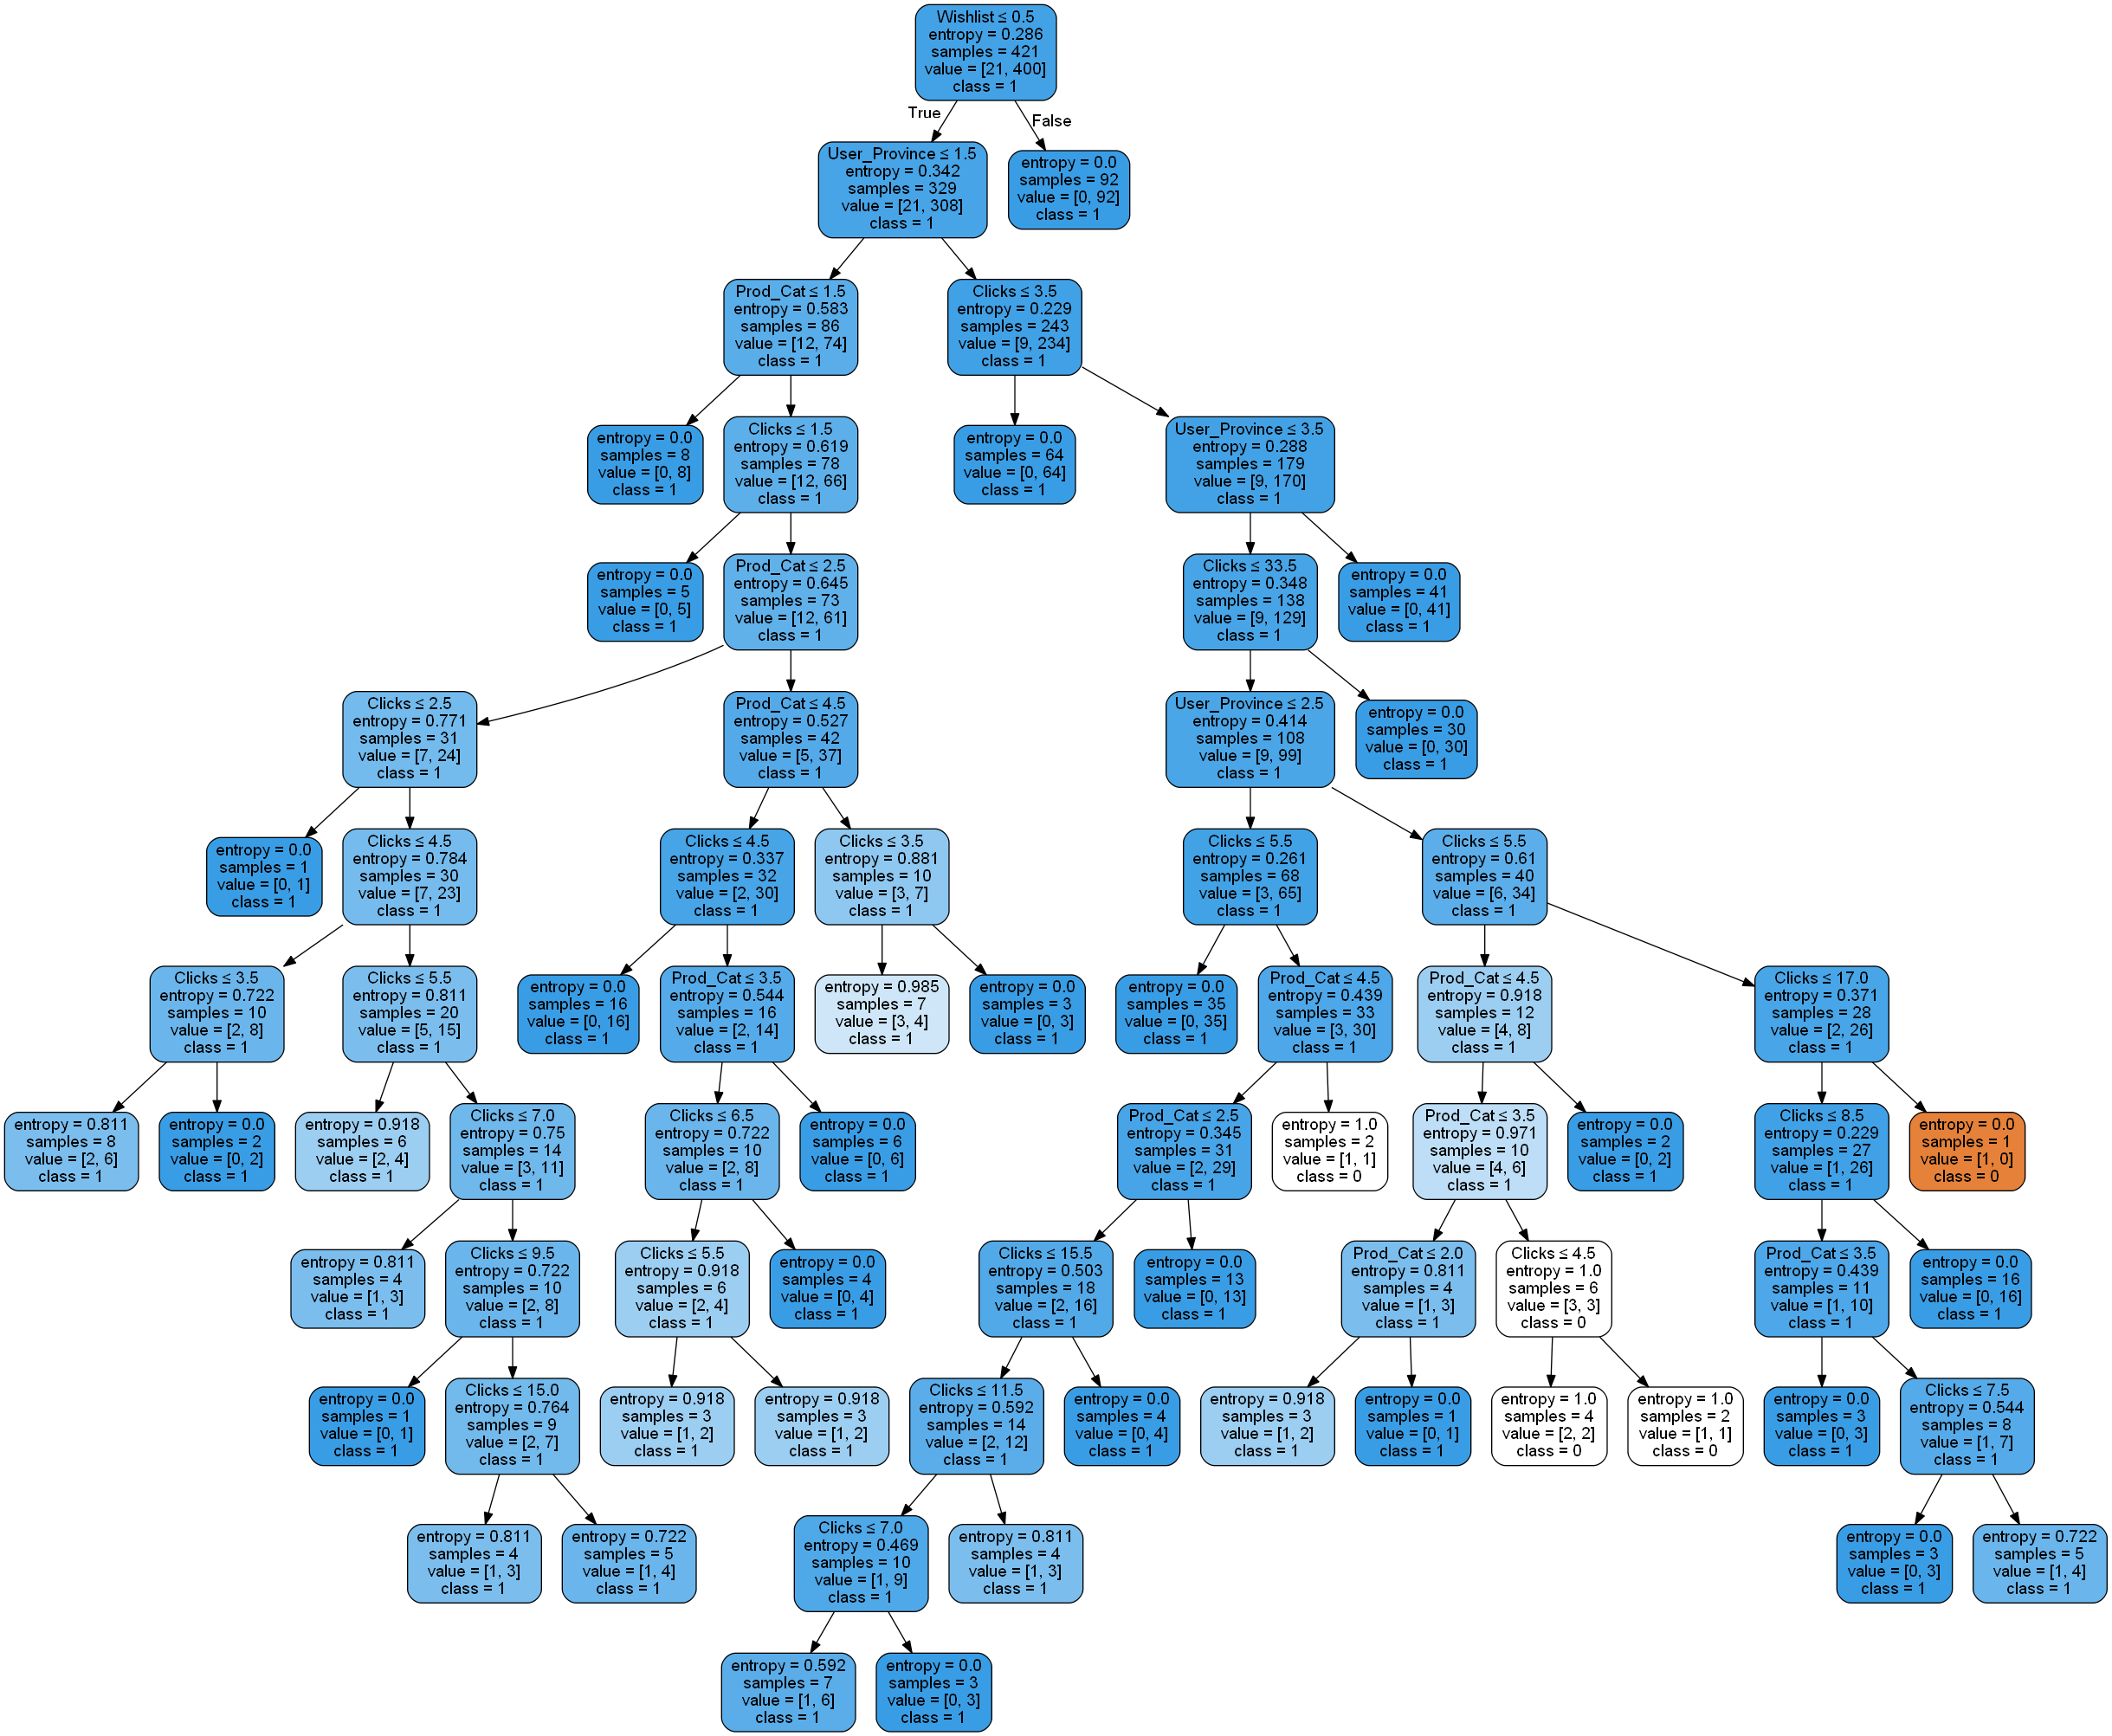

In [16]:
#Performance testing using our validation data..... X_test was initialised as a validation set...

#Before Pruning!!!!!!!!!!!!!!!!!!!!!!!!
y_predict = clf.predict(X_test)

#Get the accuracy of the model clf...

AccuracyBeforePruning = metrics.accuracy_score(y_test, y_predict)
print("-----------------------------------------------ACCURACY BEFORE PRUNING---------------------------------\n")
print(colored(AccuracyBeforePruning, 'green'))
print("\n-------------------------------------------------------------------------------------------------------\n")


#Building the decision tree, the visual decision tree diagram and exporting the diagram as .png and 
# saved under the assests folder in our project... 
r = export_text(clf, feature_names=feature_cols)

print(colored(r, 'blue'))

dot_data = StringIO()

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('../../assets/decision_tree/decision_tree_outputs/recommendations.png')
Image(graph.create_png())

-----------------------------------------------ACCURACY AFTER PRUNING-------------------------------

0.9645390070921985

-------------------------------------------------------------------------------------------------------

|--- Wishlist <= 0.50
|   |--- User_Province <= 1.50
|   |   |--- Prod_Cat <= 1.50
|   |   |   |--- class: 1
|   |   |--- Prod_Cat >  1.50
|   |   |   |--- Clicks <= 1.50
|   |   |   |   |--- class: 1
|   |   |   |--- Clicks >  1.50
|   |   |   |   |--- class: 1
|   |--- User_Province >  1.50
|   |   |--- Clicks <= 3.50
|   |   |   |--- class: 1
|   |   |--- Clicks >  3.50
|   |   |   |--- User_Province <= 3.50
|   |   |   |   |--- class: 1
|   |   |   |--- User_Province >  3.50
|   |   |   |   |--- class: 1
|--- Wishlist >  0.50
|   |--- class: 1



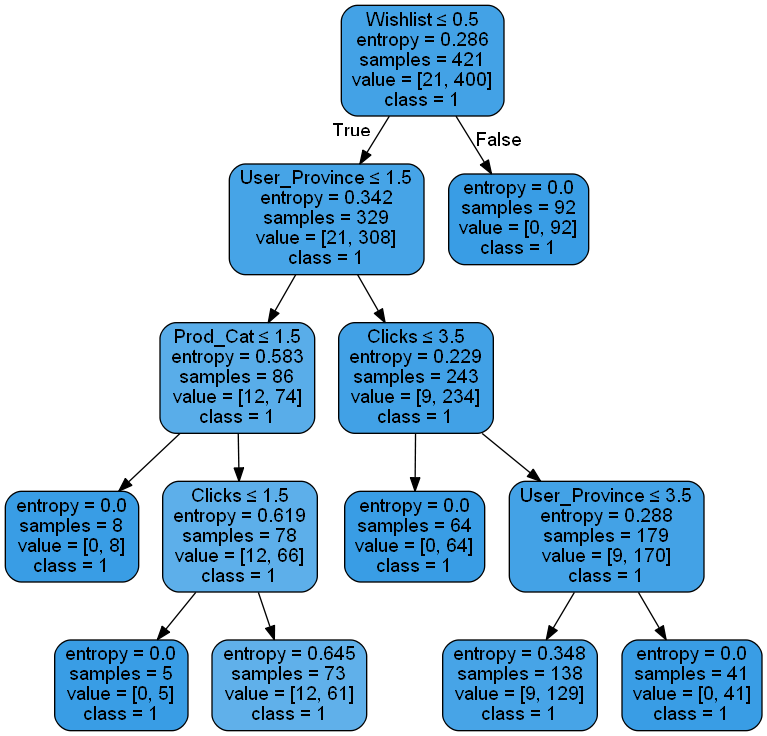

In [18]:
#After Pruning!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#We prune the tree to reduce the complexity, makes it easier to interpret 
# by cutting off the redundency of some nodes of the tree... 
# 
#Sometimes there's a tradeoff between removing redundency and a slight decrease in model accuracy... A fair tradeoff....
# what's good about our model is that most of the time the accuracy before and after pruning is likely the same, or even better after pruning

clf = DecisionTreeClassifier(criterion="entropy", max_depth=4) #Given a depth of 4 to make the tree less complicated(Avoid overfitting)

clf = clf.fit(X_train,y_train) #Train it again...

y_pred = clf.predict(X_test)

AccuracyAfterPruning = metrics.accuracy_score(y_test, y_pred)

r = export_text(clf, feature_names=feature_cols)

if(AccuracyBeforePruning <= AccuracyAfterPruning):
    print("-----------------------------------------------ACCURACY AFTER PRUNING-------------------------------\n")
    print(colored(AccuracyAfterPruning, 'green'))
    print("\n-------------------------------------------------------------------------------------------------------\n")

    print(colored(r, 'green'))
else:
    print("-----------------------------------------------ACCURACY AFTER PRUNING-------------------------------\n")
    print(colored(AccuracyAfterPruning, 'red'))
    print("\n-------------------------------------------------------------------------------------------------------\n")

    print(colored(r, 'red'))

dot_data = StringIO()

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('../../assets/decision_tree/decision_tree_outputs/recommendations(Pruned).png')
Image(graph.create_png())


In [19]:
#Exporting and saving our accuracy file in a form Accuracy Before Pruning, Accuracy After Pruning
accuracy = []
accuracy.append(AccuracyBeforePruning)
accuracy.append(AccuracyAfterPruning)
np.savetxt("../../assets/decision_tree/decision_tree_outputs/accuracies.csv", accuracy, delimiter=",", fmt='%s')

#Exporting our final files to firebase (Note these are global files, files that do not depend on the user -- hence we didn't push the final _recommendations.csv file)
#First we append them into an array...
ai_results = []

ai_results.append('decision_tree/decision_tree_outputs/recommendations.png')
ai_results.append('decision_tree/decision_tree_outputs/recommendations(Pruned).png')
ai_results.append('decision_tree/decision_tree_outputs/accuracies.csv')

for x in ai_results:

    bucket = storage.bucket()
    blob = bucket.blob(x)
    outfile='../../assets/' + x
    with open(outfile, 'rb') as my_file:
        blob.upload_from_file(my_file)

